In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [30]:
!ls ./人脸关键点检测挑战赛_数据集/ -l

总用量 611464
-rw-rw-r-- 1 lyz lyz     49324 8月   5 16:54 sample_submit.csv
-rw-rw-r-- 1 lyz lyz 151068800 7月  31 18:11 test.npy
-rw-rw-r-- 1 lyz lyz  30636709 8月   5 16:57 test.npy.zip
-rw-rw-r-- 1 lyz lyz    577557 8月   5 16:54 train.csv
-rw-rw-r-- 1 lyz lyz 368640128 7月  31 18:11 train.npy
-rw-rw-r-- 1 lyz lyz  75144987 8月   5 16:57 train.npy.zip


In [2]:
train_df = pd.read_csv('人脸关键点检测挑战赛_数据集/train.csv')
train_df = train_df.fillna(48)
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.342364,38.523613,28.930840,35.577773,49.256845,68.275955,47.783946,85.361582
1,68.912604,31.409117,29.652226,33.028075,51.913358,48.408453,50.698868,79.574038
2,68.708994,40.371149,27.130820,40.940680,44.502523,69.988486,45.926427,86.221009
3,65.334176,35.471878,29.366461,37.767684,50.411373,64.934767,50.028780,74.883241
4,68.634857,29.999486,31.094571,29.616429,50.247429,51.450857,47.948571,84.394286


In [11]:
train_img = np.load('人脸关键点检测挑战赛_数据集/train.npy')
test_img = np.load('人脸关键点检测挑战赛_数据集/test.npy')

print(train_img.shape, test_img.shape)

(96, 96, 5000) (96, 96, 2049)


Populating the interactive namespace from numpy and matplotlib


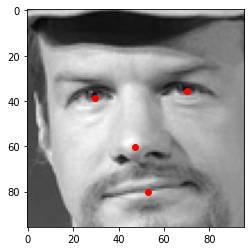

In [12]:
%pylab inline
idx = 409
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1], c='r')
plt.imshow(train_img[:, :, idx], cmap='gray')

Populating the interactive namespace from numpy and matplotlib


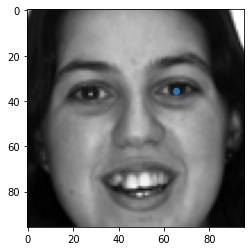

In [13]:
%pylab inline
idx = 400
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:1, 0], xy[:1, 1])
plt.imshow(train_img[:, :, idx], cmap='gray')

In [14]:
xy.flatten()

array([65.48003042, 35.59519392, 27.88015209, 37.40276806, 48.84939924,
       55.8413384 , 50.29560456, 88.92228137])

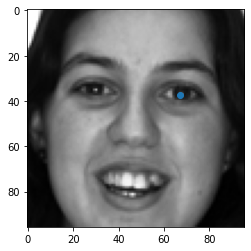

In [15]:
import albumentations as A

transform = A.Compose(
    [A.HorizontalFlip(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transformed = transform(image=train_img[:, :, idx], keypoints=xy)
transformed['keypoints'] = np.array(transformed['keypoints'])

plt.scatter(transformed['keypoints'][1, 0], transformed['keypoints'][1, 1])
plt.imshow(transformed['image'], cmap='gray')

In [10]:
# 标签次序
transformed['keypoints'][[1, 0, 2, 3]]

array([[67.11984791, 37.40276806],
       [29.51996958, 35.59519392],
       [46.15060076, 55.8413384 ],
       [44.70439544, 88.92228137]])

In [3]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [135]:
class XunFeiDataset(Dataset):
    def __init__(self, img, keypoint, train=True, transform=None):
        self.img = img
        self.transform = transform
        self.keypoint = keypoint
        self.train = train
        
        self.totensor = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
        ])
        
        self.transform1 = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=1),
            A.RandomContrast(p=1),
            A.RandomBrightnessContrast(p=1)
        ], keypoint_params=A.KeypointParams(format='xy'))

        self.transform2 = A.Compose([
            # A.Resize(224, 224),
            # A.PadIfNeeded(120, 120, p=0.5),
            A.Blur(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomContrast(p=0.5),
            A.Resize(224, 224),
        ], keypoint_params=A.KeypointParams(format='xy'))
        
    def __getitem__(self, index):
        if self.train:
            rnd = np.random.randint(10)
            if rnd > 5:
                img = self.transform1(image=self.img[:, :, index].astype(np.uint8), 
                                     keypoints=self.keypoint[index].reshape(-1, 2))
                xy = img['keypoints']
                img = img['image'].astype(np.uint8)
                img = Image.fromarray(img).convert('RGB')
                xy = np.array(xy)
                xy = xy[[1, 0, 2, 3]]
            else:
                img = self.transform2(image=self.img[:, :, index].astype(np.uint8), 
                                     keypoints=self.keypoint[index].reshape(-1, 2))
                xy = img['keypoints']
                img = img['image'].astype(np.uint8)
                img = Image.fromarray(img).convert('RGB')
                xy = np.array(xy)
            
            return self.totensor(img), xy.flatten() / 224
        else:
            img = Image.fromarray(self.img[:, :, index]).convert('RGB')
            return self.totensor(img), self.keypoint[index] / 96.0

        img = Image.fromarray(self.img[:, :, index]).convert('RGB')
        return self.totensor(img), self.keypoint[index] / 96.0

    def __len__(self):
        return self.img.shape[-1]

In [136]:
import timm

class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        self.model = timm.create_model('efficientnet_b0', num_classes=8, 
                          pretrained=True)
        
    def forward(self, img, labels=None):        
        feat = self.model(img)
        return feat

In [137]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True).float()
        target = target.cuda(non_blocking=True).float()

        output = model(input, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
            
def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda().float()
            target = target.cuda().float()
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
    return val_feats

In [132]:
os.unlink('submit.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'submit.csv'

In [138]:
def run_kfold(nfold=5):
    
    train_img = np.load('人脸关键点检测挑战赛_数据集/train.npy')
    test_img = np.load('人脸关键点检测挑战赛_数据集/test.npy')
    train_df = pd.read_csv('人脸关键点检测挑战赛_数据集/train.csv')
    train_df = train_df.fillna(48)

    if os.path.exists('submit.csv'):
        print('开始伪标签！')
        train_img = np.concatenate([train_img, test_img],axis=2)
        train_df = train_df.append(pd.read_csv('./submit.csv'))
    
    kfold = KFold(n_splits=nfold)
    fold = 0

    # 多折训练
    for tr_idx, val_idx, in kfold.split([1]*train_df.shape[0]):
        print(len(tr_idx), len(val_idx))
        train_loader = torch.utils.data.DataLoader(
            XunFeiDataset(train_img[:, :, tr_idx[:]], train_df.values[tr_idx[:]], train=True),
            batch_size=20, shuffle=True, num_workers=5,
        )

        val_loader = torch.utils.data.DataLoader(
            XunFeiDataset(train_img[:, :, val_idx[:]], train_df.values[val_idx[:]],train=False),
            batch_size=10, shuffle=False, num_workers=5,
        )

        model = XunFeiNet().cuda()
        criterion = nn.L1Loss().cuda()
        optimizer = torch.optim.Adam(model.parameters(), 0.0005)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.85)
        best_mae = 100000

        for epoch in range(20):
            train(train_loader, model, criterion, optimizer, epoch)

            val_feats = validate(val_loader, model)
            scheduler.step()

            val_feats = np.vstack(val_feats) * 96
            val_mae  = mean_absolute_error(val_feats, train_df.values[val_idx[:]])
            print(f'FOLD: {fold}, Epoch: {epoch}, Val MAE: {val_mae}')

            if val_mae < best_mae:
                best_mae = val_mae
                torch.save(model.state_dict(), 'model_{0}.pt'.format(fold))

        fold += 1
        
    
    # 对测试集进行预测
    test_loader = torch.utils.data.DataLoader(
        XunFeiDataset(test_img, np.zeros((2049, 8)), train=False),
        batch_size=10, shuffle=False, num_workers=5,
    )
    
    pred_tta = []
    for path in ['model_0.pt','model_1.pt','model_2.pt',
                'model_3.pt','model_4.pt']:
        pred = []
        model.load_state_dict(torch.load(path))
        with torch.no_grad():
            for t, (x, y) in enumerate(test_loader):
                x_var = Variable(x).cuda(async=True)
                y_var = Variable(y).cuda()
                scores0 = model(x_var)

                pred.append(scores0.data.cpu().numpy())
        pred = np.concatenate(pred, 0)    
        print(path)
        pred_tta.append(pred)

    pred = np.mean(pred_tta, axis=0)
    
    col = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
     'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 
     'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
    pd.DataFrame(pred * 96, columns=col).to_csv('submit.csv', index=None)

In [139]:
train_loader = run_kfold(5)

4000 1000
FOLD: 0, Epoch: 0, Val MAE: 4.007879647503702
FOLD: 0, Epoch: 1, Val MAE: 3.160726108417814
FOLD: 0, Epoch: 2, Val MAE: 2.875253217740549
FOLD: 0, Epoch: 3, Val MAE: 3.132796136981596
FOLD: 0, Epoch: 4, Val MAE: 2.5521866364328707
FOLD: 0, Epoch: 5, Val MAE: 3.1634699422751744
FOLD: 0, Epoch: 6, Val MAE: 2.6442081154392203
FOLD: 0, Epoch: 7, Val MAE: 2.026784245948009
FOLD: 0, Epoch: 8, Val MAE: 2.042465712749802
FOLD: 0, Epoch: 9, Val MAE: 2.481527537070486
FOLD: 0, Epoch: 10, Val MAE: 2.8717050563018858
FOLD: 0, Epoch: 11, Val MAE: 2.022664466270757
FOLD: 0, Epoch: 12, Val MAE: 1.9961034726297004
FOLD: 0, Epoch: 13, Val MAE: 1.8407943799086877
FOLD: 0, Epoch: 14, Val MAE: 1.99268680559512
FOLD: 0, Epoch: 15, Val MAE: 2.0938419387689162
FOLD: 0, Epoch: 16, Val MAE: 1.8903616699952805
FOLD: 0, Epoch: 17, Val MAE: 1.9720299292491095
FOLD: 0, Epoch: 18, Val MAE: 2.120324570925
FOLD: 0, Epoch: 19, Val MAE: 1.7580279181903458
4000 1000
FOLD: 1, Epoch: 0, Val MAE: 5.33484716505999

In [140]:
# 备份一份临时结果，提交这个是1.36得分
!cp submit.csv submit1.csv

In [ ]:
run_kfold(8)

开始伪标签！
6167 882
FOLD: 0, Epoch: 0, Val MAE: 3.5701558894283805
FOLD: 0, Epoch: 1, Val MAE: 2.863587189053993
FOLD: 0, Epoch: 2, Val MAE: 2.710825937434638
FOLD: 0, Epoch: 3, Val MAE: 2.4546196571536543
FOLD: 0, Epoch: 4, Val MAE: 2.184992664020717
FOLD: 0, Epoch: 5, Val MAE: 2.1174531636163283
FOLD: 0, Epoch: 6, Val MAE: 2.3241402249072864
FOLD: 0, Epoch: 7, Val MAE: 2.320474472824639
FOLD: 0, Epoch: 8, Val MAE: 2.1162108956192656
FOLD: 0, Epoch: 9, Val MAE: 2.3087200100310863
FOLD: 0, Epoch: 10, Val MAE: 2.304674695913043
FOLD: 0, Epoch: 11, Val MAE: 2.271806517182358
FOLD: 0, Epoch: 12, Val MAE: 1.8565682531181595
FOLD: 0, Epoch: 13, Val MAE: 1.8924639399499368
FOLD: 0, Epoch: 14, Val MAE: 1.7838219340688228
FOLD: 0, Epoch: 15, Val MAE: 2.987755642896274
FOLD: 0, Epoch: 16, Val MAE: 2.458419813455194
FOLD: 0, Epoch: 17, Val MAE: 4.4290460556808
FOLD: 0, Epoch: 18, Val MAE: 2.5309313781885394
FOLD: 0, Epoch: 19, Val MAE: 3.453123693019293
6168 881
FOLD: 1, Epoch: 0, Val MAE: 74.825821

In [52]:
# 备份一份临时结果，这个结果有可能更好
!cp submit.csv submit2.csv

array([1.])